In [ ]:
!rm -r sample_data

In [ ]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random
from os import listdir
from os.path import isfile
from typing import Tuple, List, Dict, Generator, Any
import gc
from IPython.display import clear_output

# Dataset
**GID Dataset**. Ref: https://x-ytong.github.io/project/GID.html

## Download

In [ ]:
!wget https://fruitourist.ru/cloud/gid_fine/image_RGB.zip

--2023-03-05 13:54:00--  https://fruitourist.ru/cloud/gid_fine/image_RGB.zip
Resolving fruitourist.ru (fruitourist.ru)... 95.163.237.30
Connecting to fruitourist.ru (fruitourist.ru)|95.163.237.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1459511358 (1.4G) [application/zip]
Saving to: ‘image_RGB.zip’

image_RGB.zip       100%[===================>]   1.36G  25.7MB/s    in 56s     

2023-03-05 13:54:57 (24.8 MB/s) - ‘image_RGB.zip’ saved [1459511358/1459511358]



In [ ]:
!wget https://fruitourist.ru/cloud/gid_fine/label_15classes.zip

--2023-03-05 13:54:57--  https://fruitourist.ru/cloud/gid_fine/label_15classes.zip
Resolving fruitourist.ru (fruitourist.ru)... 95.163.237.30
Connecting to fruitourist.ru (fruitourist.ru)|95.163.237.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1520764210 (1.4G) [application/zip]
Saving to: ‘label_15classes.zip’

label_15classes.zip 100%[===================>]   1.42G  25.6MB/s    in 61s     

2023-03-05 13:55:59 (23.8 MB/s) - ‘label_15classes.zip’ saved [1520764210/1520764210]



In [ ]:
!wget https://fruitourist.ru/cloud/gid_fine/readme.txt

--2023-03-05 13:55:59--  https://fruitourist.ru/cloud/gid_fine/readme.txt
Resolving fruitourist.ru (fruitourist.ru)... 95.163.237.30
Connecting to fruitourist.ru (fruitourist.ru)|95.163.237.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 492 [text/plain]
Saving to: ‘readme.txt’

readme.txt          100%[===================>]     492  --.-KB/s    in 0s      

2023-03-05 13:55:59 (104 MB/s) - ‘readme.txt’ saved [492/492]



In [ ]:
%%capture
!unzip image_RGB.zip
!unzip label_15classes.zip

In [ ]:
!rm image_RGB.zip
!rm label_15classes.zip

## Organization and Augmentation

In [ ]:
!mkdir dataset dataset/labeled

In [ ]:
classes = {
    (0, 0, 0): (0, '__background__'),
    # (200, 0, 0): (1, 'industrial_land'),
    # (250, 0, 150): (2, 'urban_residential'),
    # (200, 150, 150): (3, 'rural_residential'),
    # (250, 150, 150): (4, 'traffic_land'),
    (0, 200, 0): (1, 'paddy_field'),
    # (150, 250, 0): (2, 'irrigated_land'),
    # (150, 200, 150): (3, 'dry_cropland'),
    # (200, 0, 200): (4, 'garden_plot'),
    # (150, 0, 250): (5, 'arbor_woodland'),
    # (150, 150, 250): (6, 'shrub_land'),
    # (250, 200, 0): (7, 'natural_grassland'),
    # (200, 200, 0): (8, 'artifical_grassland'),
    # (0, 0, 200): (13, 'river'),
    # (0, 150, 200): (14, 'lake'),
    # (0, 200, 250): (15, 'pond')
}

# Промышленные земли
# Городские жилые помещения
# Сельские жилые помещения
# Дорожные земли
# Рисовые поля
# Орошаемые земли
# Сухие пахотные земли
# Садовый участок
# Лесополоса
# Земельные участки
# Естественные пастбища
# Искусственные пастбища
# Река
# Озеро
# Пруд

In [ ]:
def get_subimages_generator(
    image: Image.Image,
    subimage_size: tuple
) -> Generator[Image.Image, None, None]:
  for r in range(image.size[1] // subimage_size[1]):
    for c in range(image.size[0] // subimage_size[0]):
      yield image.crop(box=(
              c * subimage_size[0],
              r * subimage_size[1],
              (c + 1) * subimage_size[0],
              (r + 1) * subimage_size[1]
          )
      )

In [ ]:
def save_dataset_subimages(
    add_flipped: bool = True,
    add_rotated: bool = True
):
  '''...
     Augmentation:
     [x] Flip (horizontal, vertical)
     [x] Rotate (90, 180, 270)
     [ ] Change contrast
     [ ] Change gamma
     [ ] Change hue
     [ ] Noise
  '''
  for i, filename in enumerate(listdir('image_RGB/')):
      filename_without_extension = filename[:filename.rfind('.')]
      image = Image.open(fp=f'image_RGB/{filename_without_extension}.tif').crop(box=(16, 40, 7200 - 16, 6800 - 40))
      image_labeled = Image.open(fp=f'label_15classes/{filename_without_extension}_label.tif').crop(box=(16, 40, 7200 - 16, 6800 - 40))
      subimages = get_subimages_generator(image=image, subimage_size=(224,224))
      subimages_labeled = get_subimages_generator(image=image_labeled, subimage_size=(224,224))
      for si, subimage in enumerate(subimages):
        subimage_labeled = next(subimages_labeled)

        subimage.save(fp=f'dataset/i{i}si{si}.tif')
        subimage_labeled.save(fp=f'dataset/labeled/i{i}si{si}_labeled.tif')

        if add_flipped:
          for transpose_flip_method in (Image.FLIP_LEFT_RIGHT, Image.FLIP_TOP_BOTTOM):
            subimage_copy = subimage.transpose(method=transpose_flip_method)
            subimage_copy_labeled = subimage_labeled.transpose(method=transpose_flip_method)

            f = 'H' if transpose_flip_method == Image.FLIP_LEFT_RIGHT else 'V'
            subimage_copy.save(fp=f'dataset/i{i}si{si}f{f}.tif')
            subimage_copy_labeled.save(fp=f'dataset/labeled/i{i}si{si}f{f}_labeled.tif')

        if add_rotated:
          for r in (90, 180, 270):
            subimage_copy = subimage.rotate(angle=r)
            subimage_copy_labeled = subimage_labeled.rotate(angle=r)

            subimage_copy.save(fp=f'dataset/i{i}si{si}r{r}.tif')
            subimage_copy_labeled.save(fp=f'dataset/labeled/i{i}si{si}r{r}_labeled.tif')

In [ ]:
save_dataset_subimages(add_flipped=False, add_rotated=False)

## Support functions

In [ ]:
def get_dataset_subimage(
    dataset_subimage_id: str
) -> Tuple[Image.Image, Image.Image]:

  subimage = Image.open(fp=f'dataset/{dataset_subimage_id}.tif')
  subimage_labeled = Image.open(fp=f'dataset/labeled/{dataset_subimage_id}_labeled.tif')

  return subimage, subimage_labeled

In [ ]:
def get_subimage_mask(
    subimage_labeled: Image.Image,
    classes: Dict[Tuple[int, int, int], Tuple[int, str]]
) -> np.ndarray:

  subimage_labeled_ndarray = np.asarray(a=subimage_labeled)
  subimage_mask = np.zeros(shape=(len(classes), subimage_labeled.size[0], subimage_labeled.size[1]), dtype=np.float16)

  for r in range(len(subimage_labeled_ndarray)):
    for c in range(len(subimage_labeled_ndarray[r])):
      rgb_tuple = tuple(subimage_labeled_ndarray[r][c])
      class_value = classes.get(rgb_tuple)
      if class_value:
        subimage_mask[class_value[0]][r][c] = 1.0
      else:
        subimage_mask[0][r][c] = 1.0

  return subimage_mask

In [ ]:
def image_preprocess(
    image: Image.Image
) -> torch.Tensor:

  preprocess = torchvision.transforms.Compose(transforms=[
      torchvision.transforms.ToTensor()
  ])

  image_preprocessed = preprocess(img=image)

  return image_preprocessed

In [ ]:
def dataset_subimage_to_tensor(
    subimage: Image.Image,
    subimage_labeled: Image.Image,
    classes: Dict[Tuple[int, int, int], Tuple[int, str]]
) -> Tuple[torch.Tensor, torch.Tensor]:

  subimage_tensor = image_preprocess(image=subimage)
  subimage_mask_tensor = torch.tensor(
      data=get_subimage_mask(
          subimage_labeled=subimage_labeled,
          classes=classes
      ),
      dtype=torch.float16
  )

  return subimage_tensor, subimage_mask_tensor

In [ ]:
def get_subimage_labeled_from_mask(
    subimage_labeled_mask: torch.Tensor,
    classes: Dict[Tuple[int, int, int], Tuple[int, str]]
) -> Image.Image:

  subimage_labeled_ndarray = np.zeros(shape=(subimage_labeled_mask.shape[1], subimage_labeled_mask.shape[2], 3), dtype=np.uint8)

  for r in range(subimage_labeled_mask.shape[1]):
    for c in range(subimage_labeled_mask.shape[2]):
      classes_prob = [subimage_labeled_mask[class_idx][r][c] for class_idx in range(len(classes))]
      max_class_prob_idx = np.argmax(a=classes_prob)
      max_class_prob_val = classes_prob[max_class_prob_idx]
      if max_class_prob_val >= 0.51:
        for rgb_tuple, class_value in classes.items():
          if max_class_prob_idx == class_value[0]:
            subimage_labeled_ndarray[r][c] = np.array(object=rgb_tuple, dtype=np.uint8)
            break
      else:
        subimage_labeled_ndarray[r][c] = np.array(object=(255, 255, 255), dtype=np.uint8)
  
  subimage_labeled = Image.fromarray(obj=subimage_labeled_ndarray)
  
  return subimage_labeled

In [ ]:
def get_dataset_generators(
    num_train_dataset: int,
    batch_size: int,
    classes: Dict[Tuple[int, int, int], Tuple[int, str]],
    shuffle: bool = True
) -> Tuple[
    Generator[Tuple[torch.Tensor, torch.Tensor], None, None],
    Generator[Tuple[torch.Tensor, torch.Tensor], None, None]
]:

  dataset_subimages_id = list(
      map(
          lambda filename: filename[:filename.rfind('.')],
          [path for path in listdir(path='dataset/') if isfile(path=f'dataset/{path}')]
      )
  )

  if shuffle:
    random.shuffle(x=dataset_subimages_id)

  train_dataset_subimages_id = dataset_subimages_id[:int(0.9 * len(dataset_subimages_id))]
  test_dataset_subimages_id = dataset_subimages_id[int(0.9 * len(dataset_subimages_id)):] * num_train_dataset

  def get_dataset_generator(
      dataset_subimages_id: List[str],
      batch_size: int,
      classes: Dict[Tuple[int, int, int], Tuple[int, str]]
  ) -> Generator[Tuple[torch.Tensor, torch.Tensor], None, None]:

    for b in range(round(len(dataset_subimages_id) / batch_size)):
      batch_subimages_tensor = list()
      batch_subimages_mask_tensor = list()
      for dataset_subimage_id in dataset_subimages_id[b * batch_size:(b + 1) * batch_size]:
        subimage = Image.open(fp=f'dataset/{dataset_subimage_id}.tif')
        subimage_labeled = Image.open(fp=f'dataset/labeled/{dataset_subimage_id}_labeled.tif')
        subimage_tensor, subimage_mask_tensor = dataset_subimage_to_tensor(
            subimage=subimage,
            subimage_labeled=subimage_labeled,
            classes=classes
        )
        batch_subimages_tensor.append(subimage_tensor.unsqueeze(dim=0))
        batch_subimages_mask_tensor.append(subimage_mask_tensor.unsqueeze(dim=0))
      batch_subimage_tensor = torch.cat(batch_subimages_tensor)
      batch_subimage_mask_tensor = torch.cat(batch_subimages_mask_tensor)
      yield batch_subimage_tensor, batch_subimage_mask_tensor
  
  dataset_generator_train = get_dataset_generator(
      dataset_subimages_id=train_dataset_subimages_id,
      batch_size=batch_size,
      classes=classes
  )
  dataset_generator_test = get_dataset_generator(
      dataset_subimages_id=test_dataset_subimages_id,
      batch_size=1,
      classes=classes
  )

  return dataset_generator_train, dataset_generator_test

## View

In [ ]:
subimage, subimage_labeled = get_dataset_subimage(dataset_subimage_id='i5si0')

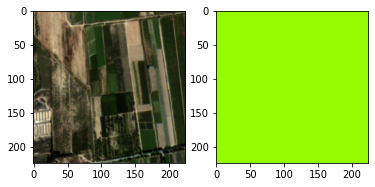

In [ ]:
fig, ax = plt.subplots(ncols=2)
ax[0].imshow(subimage)
ax[1].imshow(subimage_labeled)
plt.show()

# Model
FCN. Ref: https://arxiv.org/abs/1605.06211

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Init

In [ ]:
model = torchvision.models.segmentation.fcn_resnet101(
    num_classes=len(classes),
    weights_backbone=torchvision.models.ResNet101_Weights
)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights_backbone' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights_backbone=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights_backbone=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
%%capture
if device.type == 'cuda':
  model.to(device=device)

**WARNING** Crutch

In [ ]:
model.load_state_dict(
    state_dict=torch.load(
        'drive/MyDrive/remezov_fcn_resnet101_eps1bs32.h5',
        map_location=device
    )
)

<All keys matched successfully>

## Pretest

In [ ]:
def predict(
    device: torch.DeviceObjType,
    model: torch.nn.Module,
    image: Image.Image
) -> Image.Image:

  image_tensor = image_preprocess(image=image)

  with torch.no_grad():
    output_image_mask = model(image_tensor.unsqueeze(0).to(device))['out'][0]
  
  predicted_image_labeled = get_subimage_labeled_from_mask(
      subimage_labeled_mask=output_image_mask.cpu(),
      classes=classes
  )

  return predicted_image_labeled

In [ ]:
subimage_tensor, subimage_mask_tensor = dataset_subimage_to_tensor(
    subimage=subimage,
    subimage_labeled=subimage_labeled,
    classes=classes
)

In [ ]:
predicted_image_labeled = predict(
    device=device,
    model=model,
    image=subimage
)

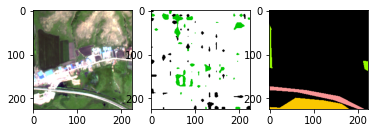

In [ ]:
fig, ax = plt.subplots(ncols=3)
ax[0].imshow(subimage)
ax[1].imshow(predicted_image_labeled)
ax[2].imshow(subimage_labeled)
plt.show()

## Metrics

In [ ]:
def metric_mean_pixel_accuracy(
    y_pred: torch.Tensor,
    y_true: torch.Tensor
) -> float:

  y_pred_hot = y_pred >= 0.51

  pixel_accuracies = list()
  for b in range(y_pred.shape[0]):
    correct_pixels = (y_pred_hot[b] == y_true[b]).count_nonzero()
    uncorrect_pixels = (y_pred_hot[b] != y_true[b]).count_nonzero()
    result = correct_pixels / (correct_pixels + uncorrect_pixels)
    pixel_accuracies.append(result)
  
  result = torch.mean(
      input=torch.tensor(data=pixel_accuracies)
  ).item()

  return result

In [ ]:
def metric_mean_iou(
    y_pred: torch.Tensor,
    y_true: torch.Tensor
) -> float:

  y_pred_hot = y_pred >= 0.51

  ious = list()
  for b in range(y_pred.shape[0]):
    intersection = torch.logical_and(y_pred_hot[b], y_true[b]).count_nonzero()
    union = torch.logical_or(y_pred_hot[b], y_true[b]).count_nonzero()
    result = intersection / union
    ious.append(result)
  
  result = torch.mean(
      input=torch.tensor(data=ious)
  ).item()

  return result

## Train

In [ ]:
def train(
    device: torch.DeviceObjType,
    model: torch.nn.Module,
    dataset_generator: Generator[Tuple[torch.Tensor, torch.Tensor], None, None],
    loss_fn: Any,
    optim_fn: Any,
    epochs: int,
    shindler: int = None
) -> Dict[str, List[float]]:

  history_metrics = {
      'loss': list(),
      'mean_pixel_accuracy': list(),
      'mean_iou': list()
  }

  for e in range(1, epochs + 1):
    for b, data in enumerate(dataset_generator, start=1):
      subimage_tensor, subimage_mask_tensor = data
      
      if device.type == 'cuda':
        subimage_tensor = subimage_tensor.to(device)
        subimage_mask_tensor = subimage_mask_tensor.to(device)
      
      optim_fn.zero_grad()
      output = model(subimage_tensor)
      loss = loss_fn(output['out'], subimage_mask_tensor)
      loss.backward()
      optim_fn.step()

      loss_item = loss.item()
      mean_pixel_accuracy = metric_mean_pixel_accuracy(output['out'], subimage_mask_tensor)
      mean_iou = metric_mean_iou(output['out'], subimage_mask_tensor)

      history_metrics['loss'].append(loss_item)
      history_metrics['mean_pixel_accuracy'].append(mean_pixel_accuracy)
      history_metrics['mean_iou'].append(mean_iou)

      clear_output()
      print('Epoch: {}. Batch: {}. Loss: {} | mAccuracy: {:.3f} | mIoU: {:.3f}'.format(
          e, b,
          loss_item, mean_pixel_accuracy, mean_iou
      ))

      del subimage_tensor
      del subimage_mask_tensor
      del output
      del loss
      del mean_pixel_accuracy
      del mean_iou
      if device.type == 'cuda':
        torch.cuda.empty_cache()
      
      if b == shindler:
        break
  
  return history_metrics

In [ ]:
dataset_generator_train, dataset_generator_test = get_dataset_generators(
    num_train_dataset=1,
    batch_size=1,
    classes=classes
)

*Loss function* is **CrossEntropyLoss**. Ref: https://arxiv.org/abs/1805.07836 \
*Optimization function* is **AdamW**. Ref: https://arxiv.org/abs/1711.05101

In [ ]:
history_metrics = train(
    device=device,
    model=model,
    dataset_generator=dataset_generator_train,
    loss_fn=torch.nn.CrossEntropyLoss(),
    optim_fn=torch.optim.AdamW(params=model.parameters()),
    epochs=1,
    shindler=8
)

In [ ]:
plt.plot(
    history_metrics['loss'], 'red',
    history_metrics['mean_pixel_accuracy'], 'green',
    history_metrics['mean_iou'], 'blue',
)
plt.title('History metrics: eps=1, bs=1, sh=8, optim=AdamW(lr=1e-3)')
plt.xlabel('Batch')
plt.ylabel('Value')
plt.legend(('Loss', 'mAccuracy', 'mIoU'))
plt.show()

**WARNING** Crutch

In [ ]:
torch.save(model.state_dict(), 'remezov_fcn_resnet101_eps1bs32sh100.h5')

In [ ]:
!mv remezov_fcn_resnet101_eps1bs32sh100.h5 drive/MyDrive

## Evaluate

In [ ]:
def evaluate(
    device: torch.DeviceObjType,
    model: torch.nn.Module,
    dataset_generator: Generator[Tuple[torch.Tensor, torch.Tensor], None, None],
    loss_fn: Any,
    shindler: int = None
) -> Dict[str, List[float]]:

  history_metrics = {
      'loss': list(),
      'mean_pixel_accuracy': list(),
      'mean_iou': list()
  }

  for b, data in enumerate(dataset_generator_test):
    subimage_tensor, subimage_mask_tensor = data

    if device.type == 'cuda':
      subimage_tensor = subimage_tensor.to(device)
      subimage_mask_tensor = subimage_mask_tensor.to(device)
    
    output = model(subimage_tensor)
    loss = loss_fn(output['out'], subimage_mask_tensor).item()
    mean_pixel_accuracy = metric_mean_pixel_accuracy(output['out'], subimage_mask_tensor)
    mean_iou = metric_mean_iou(output['out'], subimage_mask_tensor)


    history_metrics['loss'].append(loss)
    history_metrics['mean_pixel_accuracy'].append(mean_pixel_accuracy)
    history_metrics['mean_iou'].append(mean_iou)

    clear_output()
    print('Batch: {}. median Loss: {}. median Accuracy: {:.3f}. median IoU: {:.3f}'.format(
        b,
        torch.median(input=torch.tensor(data=history_metrics['loss'])),
        torch.median(input=torch.tensor(data=history_metrics['mean_pixel_accuracy'])),
        torch.median(input=torch.tensor(data=history_metrics['mean_iou']))
    ))

    del subimage_tensor
    del subimage_mask_tensor
    del output
    del loss
    del mean_pixel_accuracy
    del mean_iou
    if device.type == 'cuda':
      torch.cuda.empty_cache()
    
    if b == shindler:
      break
  
  return history_metrics

In [ ]:
history_metrics = evaluate(
    device=device,
    model=model,
    dataset_generator=dataset_generator_test,
    loss_fn=torch.nn.CrossEntropyLoss(),
    shindler=8
)

# Research

## Rosenbrock Function

In [ ]:
rosenbrock = lambda x, y: (x - 1)**2 + 100 * (y - x**2)**2

In [ ]:
X = np.arange(start=-1, stop=1, step=0.1)
Y = np.arange(start=-1, stop=1, step=0.1)

In [ ]:
X, Y = np.meshgrid(X, Y)
Z = rosenbrock(X, Y)

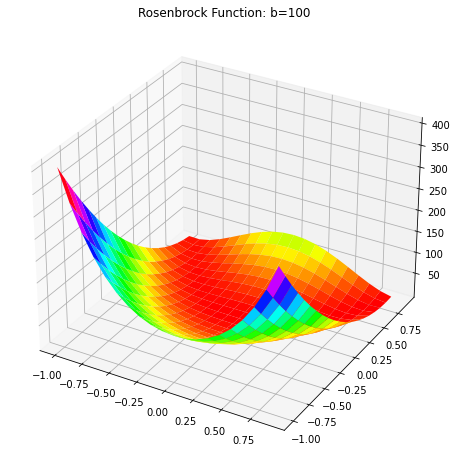

In [ ]:
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(projection='3d')
ax.plot_surface(X, Y, Z, cmap='hsv')
plt.title('Rosenbrock Function: b=100')
plt.show()